# Physics-Informed Neural Networks

In a chemical company (or life science companies in general!), it is not rare to have colleagues in research or manufacturing departments who want to develop models that must be constrained by real-world physics.
Subject Matter Experts often come with very specific requests, with the desire to couple mechanistic models with a statistical/ML model with the hope to correct or enhance the mechanistic model.

There are lots of ways to incorporate mechanistic knowledge, and this notebook we will explore Physics-Informed Neural Networks (also called PINNs in the literature).

Physics-Informed Neural Networks are a type of deep learning model that incorporates physical laws - typically expressed as differential equations (Ordinary Differential Equations, Partial Differential Equations, etc.) directly into the training process.

This approach is especially powerful for modelling systems where data is scarce but the governing physics is well understood. 

I know the theory, but I wanted to experiment with a (potentially) real example.

## Introduction to PINNS in the context of a chemical reaction

Let's consider the textbook second-order chemical reaction:

$$
2\,\mathrm{NO}_2 \rightarrow 2\,\mathrm{NO} + \mathrm{O}_2
$$

This reaction is governed by a well-known rate law (here, my mechanistic model):

$$
\frac{d[\text{NO}_2]}{dt} = - k[\text{NO}_2]^2 
$$

This is a non-linear ordinary differential equation (ODE) describing how the concentration of NO<sub>2</sub> changes over time, and wants to have a model to be able to predict the concentration of $\text{NO}_2$ during the batch reaction.

It can also be written like this:
$$
\frac{d[\text{NO}_2]}{dt} + k[\text{NO}_2]^2 =0
$$

Let's pretend a chemical engineer comes to me with 20 runs (batches) of the reaction over time.

Let's now make some synthetic "experimental" data.

### Synthesize experimental data

First, create conda env with required packages:
```
conda env create -n sandbox -f 2025-06-09_physics_informed_neural_networks.yaml
```

This re-uses exactly the same packages and versions when I created this notebook, for reproducibility.

Let's define the ideal world mechanistic model:

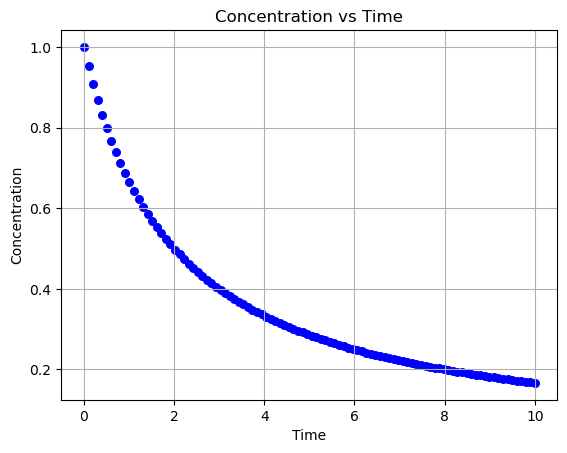

In [39]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# define the ODE
def known_ideal_reaction_rate(C, t, k):
    # C is the concentration, k is the rate constant
    return -k * C**2

# initial condition
C0 = 1.0 # initial concentration, known by chemical engineer
k = 0.5 # rate constant, known in chemical engineer's textbook
t = np.linspace(0, 10, 100) # time points
# solve the ODE
C_theory = odeint(known_ideal_reaction_rate, C0, t, args=(k,))

# plot the results
plt.scatter(t, C_theory, label='C(t)', color='blue', s=30)
plt.title('Concentration vs Time')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.grid(True)
plt.show()

Cool, but this is not real world data.

For the purpose of this exploration, we are going to assume that this mechanistic model does not capture ALL the effects (otherwise, why bother about all this if we already have a perfect model? haha)

Let's assume the chemical engineer has observed that the rate of decomposition accelerate depending on the presence or not of a purely-fictional catalyst, which we will call $Catalyst$.

The real -**unknown**- rate law is:
$$
\frac{d[\text{NO}_2]}{dt} = - k[\text{NO}_2]^2 - k_\text{catalyst}[\text{Catalyst}]^{o_\text{catalyst}} \cdot [\text{NO}_2]
$$

This is what we will want to model with our mechanistic model coupled with a ML component.

Real world data is also noisy, and there is variability in each batch. Variability is due to whatever reasons, such as not-so-tight experimental controls, as well as the catalyst concentration!

Let's synthesize our "experimental data" for 1 batch:



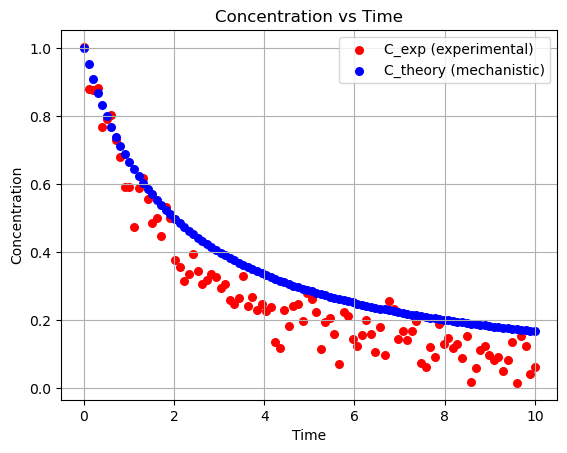

In [56]:
# define the ODE
def unknown_real_reaction_rate(C, t, k, k_cat, o_cat, C_cat):
    # C is the concentration, k is the rate constant
    # k_cat is the unknown rate constant for the catalyst, C_cat is the catalyst concentration
    # This is a more complex reaction rate that includes a catalyst accelerating decomposition
    return -k * C**2 - k_cat * C_cat**o_cat * C

# initial condition
C0 = 1 # initial concentration, known by chemical engineer
k = 0.5 # rate constant, known in chemical engineer's textbook
t = np.linspace(0, 10, 100) # time points
k_cat = 1000 # unknown by chemical engineer (black box)
o_cat = 2 # order of the catalyst, unknown by chemical engineer (black box)
C_cat = 0.01 # catalyst concentration, known by chemical engineer but changes in each batch!

def create_batch_data(C0, t, k, k_cat, o_cat, C_cat):
    # solve the ODE
    C_exp = odeint(unknown_real_reaction_rate, C0, t, args=(k, k_cat, o_cat, C_cat))
    # Add normal noise to the experimental data
    noise = np.random.normal(loc=0, scale=0.05, size=C_exp.shape)
    C_exp = C_exp + noise # shape of C_exp is (100, 1)
    C_exp[C_exp < 0] = 0 # noising can make concentration negative, set to zero
    return C_exp.flatten()

C_exp = create_batch_data(C0, t, k, k_cat, o_cat, C_cat)

# plot the results
plt.scatter(t, C_exp, label='C_exp (experimental)', color='red', s=30)
plt.scatter(t, C_theory, label='C_theory (mechanistic)', color='blue', s=30)
plt.legend()
plt.title('Concentration vs Time')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.grid(True)
plt.show()

Let's generate our experimental batches:

In [57]:
n_batches = 20

y = np.zeros((n_batches, t.shape[0])) # experimental data for each batch
X = np.zeros((n_batches, t.shape[0], 3))  # shape: (n_batches, 100, 3)

# initial condition shared by all batches
C0 = 1.0 # initial concentration, known by chemical engineer
k = 0.5 # rate constant, known in chemical engineer's textbook
t = np.linspace(0, 10, 100) # time points
k_cat = 1000 # unknown by chemical engineer (black box about catalyst reactivity)
o_cat = 2 # order of the catalyst, unknown by chemical engineer (black box)

for i in range(n_batches):
    # catalyst concentration, known by chemical engineer but changes in batches!
    C_cat = np.random.uniform(0.01, 0.05)
    C_exp = create_batch_data(C0, t, k, k_cat, o_cat, C_cat)
    # Store the experimental data in y
    y[i, :] = C_exp
    # Store the initial condition and catalyst concentration in X
    X[i, :, 0] = t  # time points for this batch
    X[i, :, 1] = C_cat  # catalyst concentration for this batch (broadcasted)
    X[i, :, 2] = i # batch index for this batch (broadcasted)

y = y.flatten()
X = X.reshape(-1, 3) # t, Ccat and batch index
# Use batch index as group
groups = X[:, 2]
X = X[:, :2] # remove the batch indices from features

print("Shape of y:", y.shape)
print("Shape of X:", X.shape)
print("Groups:", np.unique(groups))


Shape of y: (2000,)
Shape of X: (2000, 2)
Groups: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19.]


Let's plot our 'real' experimental alongside what the mechanistic model supposedly tells us:

C:\Users\alexa\AppData\Local\Temp\ipykernel_8336\2329809504.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(batch_indices))


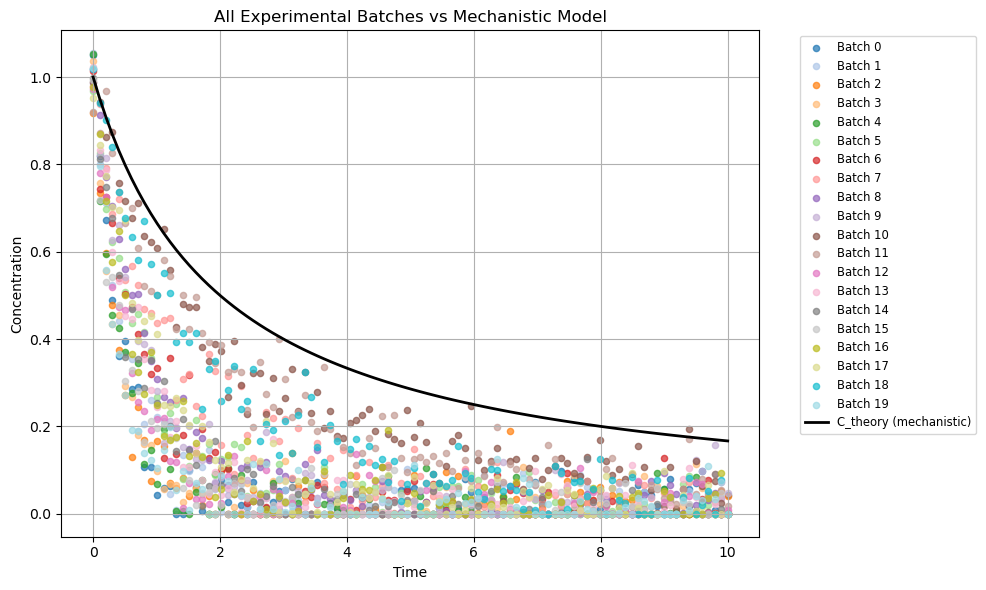

In [58]:
# Plot all experimental batches and the mechanistic theory
plt.figure(figsize=(10, 6))
batch_indices = np.unique(groups)
colors = plt.cm.get_cmap('tab20', len(batch_indices))

for idx, batch in enumerate(batch_indices):
    mask = groups[:] == batch
    plt.scatter(X[mask, 0], y[mask], color=colors(idx), label=f'Batch {int(batch)}', s=20, alpha=0.7)

plt.plot(t, C_theory.flatten(), color='black', linewidth=2, label='C_theory (mechanistic)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.title('All Experimental Batches vs Mechanistic Model')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.grid(True)
plt.tight_layout()
plt.show()

The chemical engineer has realised that the quantity of catalyst likely plays a roles. In our example, he tasks us, data scientists, to come up with a better model by incorporating the mechanistic model into a PINN.

Of course, real chemical engineers may not necessarily need us for an example like this, but we will pretend in order to test PINNs!

### Let's define our PINN

A PINN can be trained to learn the concentration profile of $\text{NO}_2$ over time by:
1. defining a neural network that takes time $t$ and $[\text{Catalyst}]$ as inputs, and the predicted concentration $\text{NO}_2$ as output
2. Embedding the ODE into the loss function. The network is penalized not only for deviating from known data points, but also for violating the ODE:
$$
\text{Loss} = (1 - \lambda) \cdot \text{Data Loss} + \lambda \cdot \text{Physic Loss}
$$
$$
\text{Loss} = (1 - \lambda) \cdot \text{MSE} + \lambda \cdot \left\| \frac{d[\text{NO}_2]}{dt} + k[\text{NO}_2]^2 + a [\text{Catalyst}]^b \cdot [\text{NO}_2] \right\|^2
$$
where $a$ and $b$ represent unknown hyperparameters to fine-tune (with the true values being $a=k_{cat}$ and $b=o_{cat}$)

3. Training the network so that it satisfies both the data and the physics.

We have physical constraints:
$$
t \in [0, 1], [\text{NO}_2] \in [0, C_0]
$$

The benefits of using PINNs here is:
- **data efficiency**: we require less experimental data points
- **generalization**: learns solutions that obey physical laws, thus theoretically improving extrapolation
- **flexibility**: can handle complex boundary and initial conditions

Let's dive into it now!

The objective of our model is to predict the concentration of $\text{NO}_2$ in a **new batch**.

Thus, we will **not** take our testing data randomly, but rather use 4 hold-out batches to externally validate our model, and thus avoid data leakage (unseen `C_cat` values). 

In [59]:
from sklearn.model_selection import GroupShuffleSplit

# Split: 80% train, 20% test (i.e., 16 train batches, 4 test batches)
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]
train_groups, test_groups = groups[train_idx], groups[test_idx]

X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.float32)

print("Train batches: groups=", np.unique(train_groups))
print("Test batches: groups=", np.unique(test_groups))
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

Train batches: groups= [ 2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 16. 18. 19.]
Test batches: groups= [ 0.  1. 15. 17.]
X_train shape: (1600, 2)
X_test shape: (400, 2)


Let's definne our PINN:

In [71]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

tf.random.set_seed(42)

from tensorflow import keras as tf_keras
import keras
from keras import layers, models
from keras import ops
from keras.src.losses.loss import Loss, squeeze_or_expand_to_same_rank

In [72]:
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

Meat of the subject:

In [108]:
import os
import sys
import time
import datetime
import tensorflow as tf
import numpy as np

class PINN(tf.keras.Model):
    def __init__(self, 
                 t_0, x_0, u_0, 
                 t_b, x_b, u_b, 
                 t_r, x_r, 
                 Rm, Rn, Rl, depth, activ = "tanh", BN = False, 
                 w_init = "glorot_normal", b_init = "zeros", 
                 lr = 1e-3, opt = "Adam", w_0 = 1., w_b = 1., w_r = 1.,
                 f_mntr = 10, r_seed = 1234):
        
        # initialize the configuration
        super().__init__()
        self.Rm     = Rm       # input dimension
        self.Rn     = Rn       # output dimension
        self.Rl     = Rl       # internal dimension
        self.depth  = depth    # (# of hidden layers) + output layer
        self.activ  = activ    # activation function
        self.BN     = BN       # BatchNorm? 
        self.w_init = w_init   # initial weight
        self.b_init = b_init   # initial bias
        self.lr     = lr       # learning rate
        self.opt    = opt      # name of your optimizer ("SGD", "RMSprop", "Adam", etc.)
        self.w_0    = w_0      # weight for initial loss
        self.w_b    = w_b      # weight for boundary loss
        self.w_r    = w_r      # weight for residual loss
        self.r_seed = r_seed
        self.f_mntr = f_mntr
        self.data_type = tf.float32
        self.random_seed(seed = self.r_seed)
        
        # input-output pair
        self.t_0 = t_0; self.x_0 = x_0; self.u_0 = u_0   # evaluates initial condition
        self.t_b = t_b; self.x_b = x_b; self.u_b = u_b   # evaluates boundary condition
        self.t_r = t_r; self.x_r = x_r                   # evaluates domain residual
        
        # bounds
        X_r     = tf.concat([t_r, x_r], 1)
        self.lb = tf.cast(tf.reduce_min(X_r, axis = 0), self.data_type)
        self.ub = tf.cast(tf.reduce_max(X_r, axis = 0), self.data_type)
        
        # call
        self.dnn = self.dnn_init(Rm, Rn, Rl, depth)
        self.params = self.dnn.trainable_variables
        self.optimizer = self.opt_alg(self.lr, self.opt)
        
        # parameter setting
        self.D = tf.constant(.01, dtype = self.data_type)

        # track loss
        self.ep_log = []
        self.loss_log = []
        
        print("\n************************************************************")
        print("****************     MAIN PROGRAM START     ****************")
        print("************************************************************")
        print(">>>>> start time:", datetime.datetime.now())
        print(">>>>> configuration;")
        print("         dtype        :", self.data_type)
        print("         activ func   :", self.activ)
        print("         weight init  :", self.w_init)
        print("         learning rate:", self.lr)
        print("         optimizer    :", self.opt)
        print("         summary      :", self.dnn.summary())
        
    def random_seed(self, seed = 1234):
        os.environ["PYTHONHASHSEED"] = str(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
        
    def dnn_init(self, Rm, Rn, Rl, depth):
        # network configuration (N: Rm -> Rn (Rm -> Rl -> ... -> Rl -> Rn))
        network = tf.keras.Sequential()
        network.add(tf.keras.layers.InputLayer(shape=(Rm,)))
        network.add(tf.keras.layers.Lambda(lambda x: 2. * (x - self.lb) / (self.ub - self.lb) - 1.))
        
        if self.BN == True:   # False by default
            for l in range(depth - 1):
                network.add(tf.keras.layers.Dense(Rl, activation = self.activ, use_bias = False,
                                                  kernel_initializer = self.w_init, bias_initializer = self.b_init, 
                                                  kernel_regularizer = None, bias_regularizer = None, 
                                                  activity_regularizer = None, kernel_constraint = None, bias_constraint = None))
                network.add(tf.keras.layers.BatchNormalization(axis = -1, momentum = 0.99, epsilon = 0.001, 
                                                               center = True, scale = True,
                                                               beta_initializer = "zeros", gamma_initializer = "ones",
                                                               moving_mean_initializer = "zeros",
                                                               moving_variance_initializer = "ones", 
                                                               beta_regularizer = None, gamma_regularizer = None, 
                                                               beta_constraint  = None, gamma_constraint  = None))
            
        else:   # False by default
            for l in range(depth - 1):
                network.add(tf.keras.layers.Dense(Rl, activation = self.activ, use_bias = True,
                                                  kernel_initializer = self.w_init, bias_initializer = self.b_init, 
                                                  kernel_regularizer = None, bias_regularizer = None, 
                                                  activity_regularizer = None, kernel_constraint = None, bias_constraint = None))
        network.add(tf.keras.layers.Dense(Rn))
        return network
    
    def opt_alg(self, lr, opt):
        if   opt == "SGD":
            optimizer = tf.keras.optimizers.SGD(learning_rate = lr, momentum = 0.0, nesterov = False)
        elif opt == "RMSprop":
            optimizer = tf.keras.optimizers.RMSprop(learning_rate = lr, rho = 0.9, momentum = 0.0, centered = False)
        elif opt == "Adam":
            optimizer = tf.keras.optimizers.Adam(learning_rate = lr, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)
        elif opt == "Adamax":
            optimizer = tf.keras.optimizers.Adamax(learning_rate = lr, beta_1 = 0.9, beta_2 = 0.999)
        elif opt == "Nadam":
            optimizer = tf.keras.optimizers.Nadam(learning_rate = lr, beta_1 = 0.9, beta_2 = 0.999)
        else:
            raise Exception(">>>>> Exception: optimizer not specified correctly")
            
        return optimizer
    
    def PDE(self, t, x):
        t = tf.convert_to_tensor(t, dtype = self.data_type)
        x = tf.convert_to_tensor(x, dtype = self.data_type)

        with tf.GradientTape(persistent = True) as tp:
            tp.watch(t)
            tp.watch(x)
            
            u = self.dnn(tf.concat([t, x], 1))
            u_x = tp.gradient(u, x)
        u_t  = tp.gradient(u, t)
        u_xx = tp.gradient(u_x, x)
        del tp
        
        gv = u_t - self.D * u_xx
        
        return u, gv
    
    def loss_prd(self, t, x, u):
        u_hat, dummy = self.PDE(t, x)
        loss_prd = tf.reduce_mean(tf.square(u - u_hat))
        return loss_prd
        
    def loss_pde(self, t, x):
        dummy, gv_hat = self.PDE(t, x)
        loss_pde = tf.reduce_mean(tf.square(gv_hat))
        return loss_pde
    
    @tf.function
    def loss_glb(self, 
                 t_0, x_0, u_0, 
                 t_b, x_b, u_b, 
                 t_r, x_r):
        loss_0   = self.w_0 * self.loss_prd(t_0, x_0, u_0)
        loss_b   = self.w_b * self.loss_prd(t_b, x_b, u_b)
        loss_r   = self.w_r * self.loss_pde(t_r, x_r)
        loss_glb = loss_0 + loss_b + loss_r
        return loss_glb

    def loss_grad(self, 
                  t_0, x_0, u_0, 
                  t_b, x_b, u_b, 
                  t_r, x_r): 
        with tf.GradientTape(persistent = True) as tp:
            loss = self.loss_glb(t_0, x_0, u_0, 
                                 t_b, x_b, u_b, 
                                 t_r, x_r)
        grad = tp.gradient(loss, self.params)
        del tp
        return loss, grad
    
    @tf.function
    def grad_desc(self, 
                  t_0, x_0, u_0, 
                  t_b, x_b, u_b, 
                  t_r, x_r):
        loss, grad = self.loss_grad(t_0, x_0, u_0, 
                                    t_b, x_b, u_b, 
                                    t_r, x_r)
        self.optimizer.apply_gradients(zip(grad, self.params))
        return loss
        
    def train(self, epoch = 10 ** 5, batch = 2 ** 6, tol = 1e-5): 
        print(">>>>> training setting;")
        print("         # of epoch     :", epoch)
        print("         batch size     :", batch)
        print("         convergence tol:", tol)
        
        t0 = time.time()
        
        # I had to convert input data (tf.tensor) into numpy style in order for mini-batch training (slicing)
        # and this works well for both full-batch and mini-batch training
        t_0 = self.t_0.numpy(); x_0 = self.x_0.numpy(); u_0 = self.u_0.numpy()
        t_b = self.t_b.numpy(); x_b = self.x_b.numpy(); u_b = self.u_b.numpy()
        t_r = self.t_r.numpy(); x_r = self.x_r.numpy()
        
        for ep in range(epoch):
            ep_loss = 0
            
            if batch == 0:   # full-batch training
                ep_loss = self.grad_desc(t_0, x_0, u_0, 
                                         t_b, x_b, u_b, 
                                         t_r, x_r)
            
            else:   # mini-batch training
                n_0 = self.x_0.shape[0]; idx_0 = np.random.permutation(n_0)
                n_b = self.x_b.shape[0]; idx_b = np.random.permutation(n_b)
                n_r = self.x_r.shape[0]; idx_r = np.random.permutation(n_r)

                n_data = self.x_0.shape[0] + self.x_b.shape[0] + self.x_r.shape[0]
                shf_idx = np.random.permutation(n_data)

                for idx in range(0, n_r, batch):
                    # batch for initial condition
#                     t_0_btch = tf.convert_to_tensor(t_0[idx_0[idx: idx + batch if idx + batch < n_0 else n_0]], dtype = self.data_type)
#                     x_0_btch = tf.convert_to_tensor(x_0[idx_0[idx: idx + batch if idx + batch < n_0 else n_0]], dtype = self.data_type)
#                     u_0_btch = tf.convert_to_tensor(u_0[idx_0[idx: idx + batch if idx + batch < n_0 else n_0]], dtype = self.data_type)
                    t_0_btch = t_0
                    x_0_btch = x_0
                    u_0_btch = u_0
                    # batch for boudary condition
#                     t_b_btch = tf.convert_to_tensor(t_b[idx_b[idx: idx + batch if idx + batch < n_b else n_b]], dtype = self.data_type)
#                     x_b_btch = tf.convert_to_tensor(x_b[idx_b[idx: idx + batch if idx + batch < n_b else n_b]], dtype = self.data_type)
#                     u_b_btch = tf.convert_to_tensor(u_b[idx_b[idx: idx + batch if idx + batch < n_b else n_b]], dtype = self.data_type)
                    t_b_btch = t_b
                    x_b_btch = x_b
                    u_b_btch = u_b
                    # batch for domain residual
                    t_r_btch = tf.convert_to_tensor(t_r[idx_r[idx: idx + batch if idx + batch < n_r else n_r]], dtype = self.data_type)
                    x_r_btch = tf.convert_to_tensor(x_r[idx_r[idx: idx + batch if idx + batch < n_r else n_r]], dtype = self.data_type)
                    # compute loss and perform gradient descent
                    loss_btch = self.grad_desc(t_0_btch, x_0_btch, u_0_btch, 
                                               t_b_btch, x_b_btch, u_b_btch, 
                                               t_r_btch, x_r_btch)
                    ep_loss += loss_btch / int(n_r / batch)
                
            if ep % self.f_mntr == 0:
                elps = time.time() - t0
                
                self.ep_log.append(ep)
                self.loss_log.append(ep_loss)
                print("ep: %d, loss: %.6e, elps: %.3f" % (ep, ep_loss, elps))
                t0 = time.time()
            
            if ep_loss < tol:
                print(">>>>> program terminating with the loss converging to its tolerance.")
                print("\n************************************************************")
                print("*****************     MAIN PROGRAM END     *****************")
                print("************************************************************")
                print(">>>>> end time:", datetime.datetime.now())
                break
        
        print("\n************************************************************")
        print("*****************     MAIN PROGRAM END     *****************")
        print("************************************************************")
        print(">>>>> end time:", datetime.datetime.now())
                
    def infer(self, t, x):
        u_hat, gv_hat = self.PDE(t, x)
        return u_hat, gv_hat

In [109]:
# network structure
in_dim  = 2
out_dim = 1
width = 2 ** 6   # 2 ** 6 = 64, 2 ** 8 = 256
depth = 4

# training setting
n_epch = int(5e4)
n_btch = int(0)
c_tol  = 1e-8

# dataset prep
N_0 = int(1e3)   # evaluates initial condition
N_b = int(1e3)   # evaluates boundary condition
N_r = int(1e4)   # evaluates PDE residual within the domain

# optimization
w_init = "glorot_normal"
b_init = "zeros"
act = "tanh"
lr0 = 5e-3
gam = 1e-2
lrd_exp = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = lr0, 
    decay_steps = n_epch, 
    decay_rate = gam, 
    staircase = False
    )
lrd_cos = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate = lr0, 
    decay_steps = n_epch, 
    alpha = gam
    )
lr = lrd_cos   # 1e-3 / 5e-4 / lrd_exp / lrd_cos
opt = "Adam"

# weight
w_0 = 1.
w_b = 1.
w_r = 1.

# rarely change
f_mntr = 10
r_seed = 1234

print("python    :", sys.version)
print("tensorflow:", tf.__version__)
print("rand seed :", r_seed)
os.environ["PYTHONHASHSEED"] = str(r_seed)
np.random.seed(r_seed)
tf.random.set_seed(r_seed)

python    : 3.11.13 | packaged by Anaconda, Inc. | (main, Jun  5 2025, 13:03:15) [MSC v.1929 64 bit (AMD64)]
tensorflow: 2.18.1
rand seed : 1234


In [110]:
def prp_grid(tmin, tmax, nt,
            xmin, xmax, nx):
    t = np.linspace(tmin, tmax, nt)
    x = np.linspace(xmin, xmax, nx)
    t, x = np.meshgrid(t, x)
    t, x = t.reshape(-1, 1), x.reshape(-1, 1)
    TX = np.c_[t, x]
    return t, x, TX

In [111]:
def prp_dataset(tmin, tmax, xmin, xmax, N_0, N_b, N_r):
    lb = tf.constant([tmin, xmin], dtype = tf.float32)
    ub = tf.constant([tmax, xmax], dtype = tf.float32)
    print("lower bound", lb)
    print("upper bound", ub)

    t_0 = tf.ones((N_0, 1), dtype = tf.float32) * lb[0]
    x_0 = tf.random.uniform((N_0, 1), lb[1], ub[1], dtype = tf.float32)
    t_b = tf.random.uniform((N_b, 1), lb[0], ub[0], dtype = tf.float32)
    x_b = lb[1] + (ub[1] - lb[1]) * tf.keras.backend.random_bernoulli((N_b, 1), .5, dtype = tf.float32)
    t_r = tf.random.uniform((N_r, 1), lb[0], ub[0], dtype = tf.float32)
    x_r = tf.random.uniform((N_r, 1), lb[1], ub[1], dtype = tf.float32)

    return t_0, x_0, t_b, x_b, t_r, x_r

In [112]:
def func_u0(x):
    return .5 * tf.sin(np.pi * x) + .3 * tf.sin(4 * np.pi * x) + .1 * tf.sin(16 * np.pi * x)

def func_ub(x):
    n = x.shape[0]
    return tf.zeros((n, 1), dtype = tf.float32)

lower bound tf.Tensor([ 0. -1.], shape=(2,), dtype=float32)
upper bound tf.Tensor([1. 1.], shape=(2,), dtype=float32)

************************************************************
****************     MAIN PROGRAM START     ****************
************************************************************
>>>>> start time: 2025-06-10 19:45:29.266762
>>>>> configuration;
         dtype        : <dtype: 'float32'>
         activ func   : tanh
         weight init  : glorot_normal
         learning rate: <keras.src.optimizers.schedules.learning_rate_schedule.CosineDecay object at 0x000002018E99B090>
         optimizer    : Adam


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda_1 (Lambda)               │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,577 (33.50 KB)

 Trainable params: 8,577 (33.50 KB)

 Non-trainable params: 0 (0.00 B)

         summary      : None
>>>>> training setting;
         # of epoch     : 50000
         batch size     : 0
         convergence tol: 1e-08
ep: 0, loss: 3.517581e-01, elps: 2.675
ep: 10, loss: 3.484800e-01, elps: 0.400
ep: 20, loss: 1.821702e-01, elps: 0.407
ep: 30, loss: 1.714769e-01, elps: 0.385
ep: 40, loss: 1.589456e-01, elps: 0.388
ep: 50, loss: 1.559929e-01, elps: 0.390
ep: 60, loss: 1.509543e-01, elps: 0.387
ep: 70, loss: 1.397948e-01, elps: 0.398
ep: 80, loss: 1.225683e-01, elps: 0.392
ep: 90, loss: 1.009017e-01, elps: 0.386
ep: 100, loss: 8.096733e-02, elps: 0.385
ep: 110, loss: 6.678909e-02, elps: 0.381
ep: 120, loss: 5.983818e-02, elps: 0.375
ep: 130, loss: 5.817755e-02, elps: 0.375
ep: 140, loss: 5.716154e-02, elps: 0.383
ep: 150, loss: 5.600237e-02, elps: 0.386
ep: 160, loss: 5.527204e-02, elps: 0.372
ep: 170, loss: 5.472132e-02, elps: 0.378
ep: 180, loss: 5.425384e-02, elps: 0.376
ep: 190, loss: 5.387130e-02, elps: 0.378
ep: 200, loss: 5.353826e-02, elps: 0.385
ep: 2

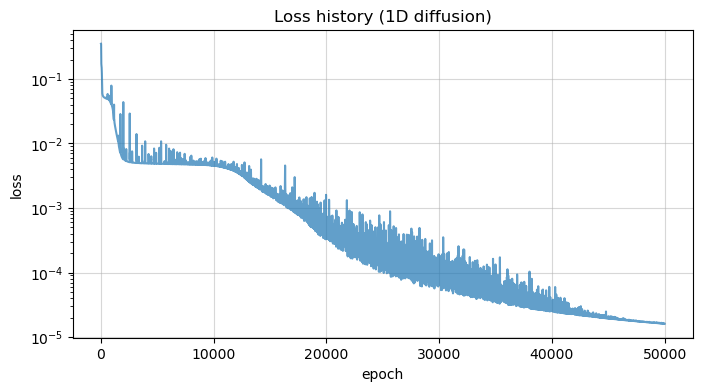

elapsed time for PINN inference (sec): 1.4604027271270752


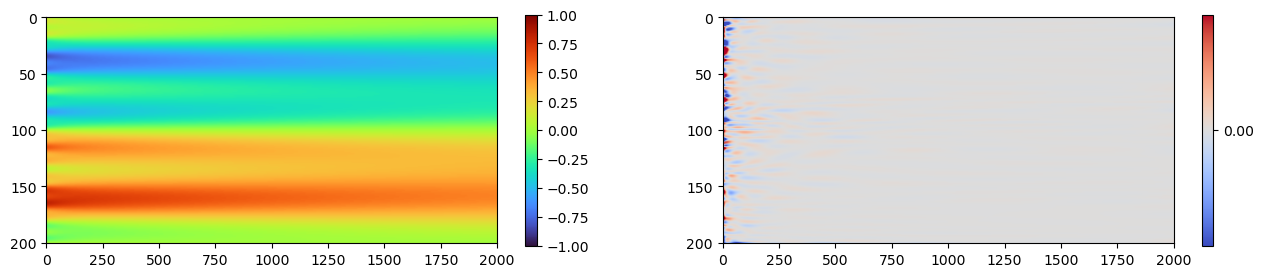

elapsed time for FDM simulation (sec): 0.8397524356842041
t: 0.000, norm_u: 4.075355e-02, mse_u: 8.262945e-06, sem_u: 9.086886e-07, norm_gv: 3.834117e+00, mse_gv: 7.313660e-02, sem_gv: 1.521818e-02


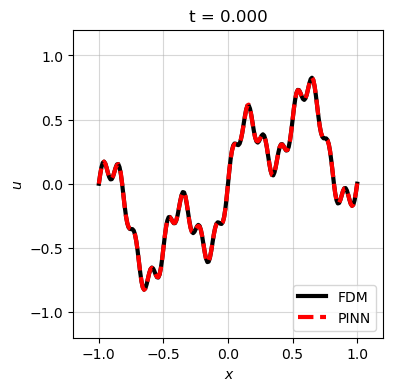

t: 0.200, norm_u: 6.708546e-03, mse_u: 2.239034e-07, sem_u: 1.894015e-08, norm_gv: 4.073711e-02, mse_gv: 8.256282e-06, sem_gv: 1.091711e-06


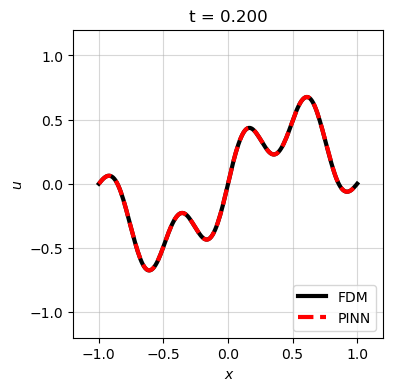

t: 0.400, norm_u: 5.845022e-03, mse_u: 1.699716e-07, sem_u: 1.438701e-08, norm_gv: 2.116908e-02, mse_gv: 2.229502e-06, sem_gv: 3.071810e-07


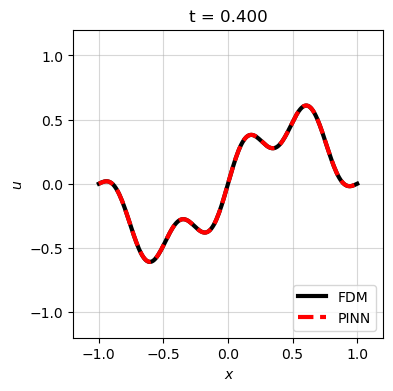

t: 0.600, norm_u: 5.374673e-03, mse_u: 1.437170e-07, sem_u: 1.204176e-08, norm_gv: 1.717157e-02, mse_gv: 1.466979e-06, sem_gv: 3.241785e-07


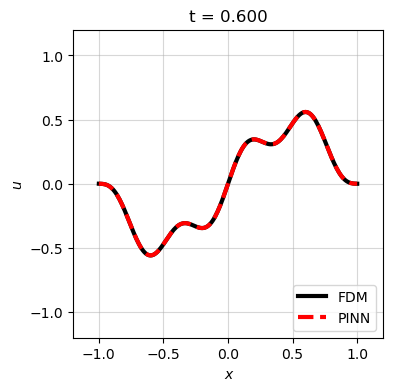

t: 0.800, norm_u: 5.131601e-03, mse_u: 1.310116e-07, sem_u: 1.155758e-08, norm_gv: 1.304346e-02, mse_gv: 8.464275e-07, sem_gv: 8.434657e-08


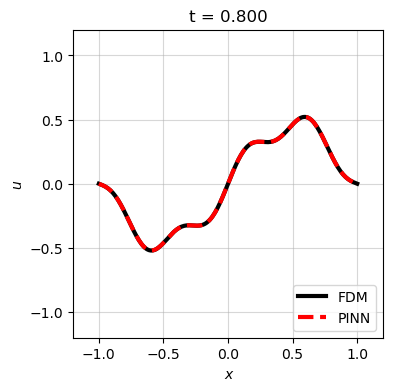

t: 1.000, norm_u: 4.875582e-03, mse_u: 1.182652e-07, sem_u: 9.457172e-09, norm_gv: 2.271594e-02, mse_gv: 2.567233e-06, sem_gv: 2.820313e-07


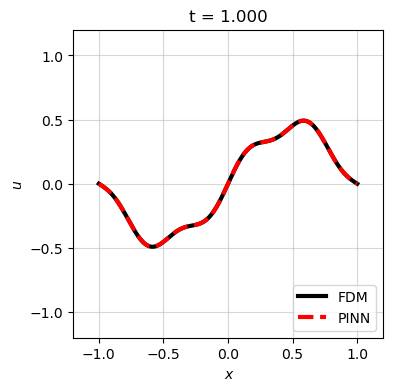

In [113]:
tmin, tmax, nt =  0., 1., int(2e3) + 1
xmin, xmax, nx = -1., 1., int(2e2) + 1
t, x, TX = prp_grid(
    tmin, tmax, nt, 
    xmin, xmax, nx
)

t_0, x_0, t_b, x_b, t_r, x_r = prp_dataset(tmin, tmax, xmin, xmax, N_0, N_b, N_r)
u_0 = func_u0(x_0)
u_b = func_ub(x_b)

pinn = PINN(t_0, x_0, u_0, 
            t_b, x_b, u_b, 
            t_r, x_r, 
            Rm = in_dim, Rn = out_dim, Rl = width, depth = depth, activ = act, 
            w_init = w_init, b_init = b_init, 
            lr = lr, opt = opt, w_0 = w_0, w_b = w_b, w_r = w_r,
            f_mntr = f_mntr, r_seed = r_seed)

#with tf.device("/device:GPU:0"):
with tf.device("/device:CPU:0"):
    pinn.train(n_epch, n_btch, c_tol)

plt.figure(figsize=(8, 4))
plt.plot(pinn.ep_log, pinn.loss_log, alpha=.7)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.yscale("log")
plt.title("Loss history (1D diffusion)")
plt.grid(alpha=.5)
plt.show()

# PINN inference
t0 = time.time()
u_hat, gv_hat = pinn.infer(t, x)
t1 = time.time()
elps = t1 - t0
print("elapsed time for PINN inference (sec):", elps)
plt.figure(figsize=(16, 3))
plt.subplot(1,2,1)
plt.imshow(u_hat.numpy().reshape(nx, nt), cmap="turbo", aspect=5, interpolation="bilinear", vmin=-1, vmax=1)
plt.colorbar(ticks = np.arange(-1, 1.1, .25))
plt.subplot(1,2,2)
plt.imshow(gv_hat.numpy().reshape(nx, nt), cmap="coolwarm", aspect=5, interpolation="bilinear", vmin=-.1, vmax=.1)
plt.colorbar(ticks = np.arange(-1, 1.1, .25))
plt.show()

# FDM 
t_num = np.linspace(tmin, tmax, nt, dtype = "float32")
x_num = np.linspace(xmin, xmax, nx, dtype = "float32")
dt_num = t_num[1] - t_num[0]
dx_num = x_num[1] - x_num[0]
D_num = pinn.D.numpy()
u_num = np.empty([nx, nt], dtype="float32")
# initial condition
for i in range(1, nx):
    u_num[i, 0] = .5 * np.sin(     np.pi * x_num[i]) \
                + .3 * np.sin( 4 * np.pi * x_num[i]) \
                + .1 * np.sin(16 * np.pi * x_num[i])
# boundary condition
u_num[ 0,:] = 0.
u_num[-1,:] = 0.

# FDM simulation
t0 = time.time()
for n in range(nt - 1):
    for i in range(1, nx - 1):
        u_num[i, n+1] =   u_num[i, n] \
                        + D_num * dt_num / dx_num ** 2 * (u_num[i+1, n] - 2 * u_num[i, n] + u_num[i-1, n])
t1 = time.time()
elps = t1 - t0
print("elapsed time for FDM simulation (sec):", elps)

# comparison
u_hat_  = u_hat .numpy().reshape(nx, nt)
gv_hat_ = gv_hat.numpy().reshape(nx, nt)
for n in range(nt):
    if n % int(nt/5) == 0:
        norm_u = np.linalg.norm(u_num[:,n] - u_hat_[:,n], 2)
        mse_u  = np.mean(np.square(u_num[:,n] - u_hat_[:,n]))
        sem_u  = np.std (np.square(u_num[:,n] - u_hat_[:,n]), ddof = 1) / np.sqrt(u_hat_[:,n].shape[0])
        norm_gv= np.linalg.norm(gv_hat_[:,n], 2)
        mse_gv = np.mean(np.square(gv_hat_[:,n]))
        sem_gv = np.std (np.square(gv_hat_[:,n]), ddof = 1) / np.sqrt(gv_hat_[:,n].shape[0])
        print("t: %.3f, norm_u: %.6e, mse_u: %.6e, sem_u: %.6e, norm_gv: %.6e, mse_gv: %.6e, sem_gv: %.6e" 
            % (n / nt, norm_u, mse_u, sem_u, norm_gv, mse_gv, sem_gv))
        
        plt.figure(figsize=(4, 4))
        plt.plot(x_num, u_num [:,n], label = "FDM",  color = "k", linestyle="-",  linewidth=3) 
        plt.plot(x_num, u_hat_[:,n], label = "PINN", color = "r", linestyle="--", linewidth=3)
        plt.xlim(-1.2, 1.2)
        plt.ylim(-1.2, 1.2)
        plt.xlabel("x", fontstyle = "italic")
        plt.ylabel("u", fontstyle = "italic")
        plt.title("t = %.3f" % (n / nt))
        plt.grid(alpha = .5)
        plt.legend(loc = "lower right")
        plt.show()

further test:

In [114]:
def mean_squared_error(y_true, y_pred):
    y_pred = ops.convert_to_tensor(y_pred)
    y_true = ops.convert_to_tensor(y_true, dtype=y_pred.dtype)
    y_true, y_pred = squeeze_or_expand_to_same_rank(y_true, y_pred)
    return ops.mean(ops.square(y_true - y_pred), axis=-1)

def mechanistic_equation(y_true, y_pred, dy_pred_dt, t, Ccat, a , b, k):   
    return ops.mean(ops.square(dy_pred_dt + k * ops.square(y_pred) + a * Ccat**b * y_pred))

class PINNLoss(Loss):
    def __init__(self, lambda_=0.0, k=0.5, a=10, b=1, reduction="sum_over_batch_size", name=None):
        super().__init__(reduction=reduction, name=name)
        self.lambda_ = lambda_
        self.k = k
        self.a = a
        self.b = b

    def call(self, y_true_packed, y_pred):
        # If y_true_packed is not the packed shape, just do MSE (for metrics/validation)
        # works for both (batch,) and (batch, 1) shapes.
        if (len(y_true_packed.shape) == 1) or (len(y_true_packed.shape) == 2 and y_true_packed.shape[1] == 1):
            print("y_true_packed shape:", y_true_packed.shape, "y_pred shape:", y_pred.shape)
            print("value ", y_true_packed, " and", y_pred)
            # fallback to standard MSE
            y_pred = ops.convert_to_tensor(y_pred)
            y_true = ops.convert_to_tensor(y_true_packed, dtype=y_pred.dtype)
            y_true, y_pred = squeeze_or_expand_to_same_rank(y_true, y_pred)
            val_data_loss = mean_squared_error(y_true, y_pred)
            if val_data_loss is None:
                raise ValueError("Data loss function must return a non-None value, even for validation.")
            print("revised y_true_packed shape:", y_true_packed.shape, "y_pred shape:", y_pred.shape)
            print("revised value ", y_true_packed, " and", y_pred)
            print("val loss:", val_data_loss)
            return val_data_loss
        
        
        print("y_true_packed shape:", y_true_packed.shape)
        # various checks, useful for debugging
        if len(y_true_packed.shape) != 2 or y_true_packed.shape[1] != 4:
            raise ValueError(f"y_true_packed must have 4 columns: [y_true, dy_pred_dt, t, Ccat]. Expected shape: (batch_size, 4), got {y_true_packed.shape}.")
        
        y_true = y_true_packed[:, 0:1]
        dy_pred_dt = y_true_packed[:, 1:2]
        t = y_true_packed[:, 2:3]
        Ccat = y_true_packed[:, 3:4]

        if dy_pred_dt is None:
            raise ValueError("Gradient tape must return a non-None value for dy_pred_dt.")
        if y_true.shape != y_pred.shape:
            raise ValueError(f"y_true and y_pred must have the same shape. Expected {y_true.shape}, got {y_pred.shape}.")
        if t.shape != dy_pred_dt.shape:
            raise ValueError(f"t and dy_pred_dt must have the same shape. Expected {t.shape}, got {dy_pred_dt.shape}.")
        if Ccat.shape != y_pred.shape:
            raise ValueError(f"Ccat and y_pred must have the same shape. Expected {Ccat.shape}, got {y_pred.shape}.")
        if y_true.dtype != y_pred.dtype:
            raise ValueError(f"y_true and y_pred must have the same dtype. Expected {y_true.dtype}, got {y_pred.dtype}.")
        if t.dtype != dy_pred_dt.dtype:
            raise ValueError(f"t and dy_pred_dt must have the same dtype. Expected {t.dtype}, got {dy_pred_dt.dtype}.")
        
        y_true, y_pred = squeeze_or_expand_to_same_rank(y_true, y_pred)
        physics_loss = mechanistic_equation(
            y_true, 
            y_pred, 
            dy_pred_dt, 
            t, 
            Ccat,
            self.a,
            self.b,
            self.k
        )
        if physics_loss is None:
            raise ValueError("Physics loss function must return a non-None value.")
        data_loss = mean_squared_error(y_true, y_pred)
        if data_loss is None:
            raise ValueError("Data loss function must return a non-None value.")
        train_total_loss = (1 - self.lambda_) * data_loss + self.lambda_ * physics_loss
        print("train total loss:", train_total_loss)
        return train_total_loss


In [115]:
class PINNModel(tf.keras.Model):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def train_step(self, data: tuple):
        print("Train step")
        print("size of data:", len(data))
        
        X, y_true = data
        # here we use a numerical gradient to compute dy/dt
        with tf.GradientTape() as tape_1:
            with tf.GradientTape(persistent=True) as tape_2:
                tape_2.watch(X)
                y_pred = self(X, training=True)
                y_pred = tf.where(y_pred < 0, 0.0, y_pred)  # Enforce non-negativity constraint
            # Assuming dy/dt is the first column of X. shape (batch_size, 1)
            dy_pred_dt = tape_2.gradient(y_pred, X)[:, 0:1] 
            #print("dy_pred_dt shape:", dy_pred_dt.shape)
            # Hack: Concatenate y_true, dy/dt and X to leverage the compiled loss function
            y_true_packed = tf.concat(
                [
                    tf.reshape(y_true, [-1, 1]), 
                    dy_pred_dt, 
                    X[:, 0:1], 
                    X[:, 1:2]
                ], 
                axis=1
            )  # shape: (batch_size, 4)
            # Call the compiled loss function
            # Note: self.compiled_loss is a callable that computes the loss
            # and applies any regularization losses
            loss = self.compute_loss(X, y_true_packed, y_pred, training=True)
        # Compute gradients and apply them
        gradients = tape_1.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        # Free memory
        del tape_1
        del tape_2
        # Update metrics (includes the metric(s) you passed in compile)
        for metric in self.metrics:
            metric.update_state(y_true, y_pred)
        # Return a dict mapping metric names to current value
        result = {
            "loss": loss,
            **{
                m.name: m.result() 
                for m in self.metrics
            }
        }
        return result
    
    def test_step(self, data: tuple):
        X, y_true = data
        print("Test step")
        print("size of data:", len(data))
        print(X, y_true)
        with tf.GradientTape(persistent=True) as tape_2:
            tape_2.watch(X)
            y_pred = self(X, training=False)
            y_pred = tf.where(y_pred < 0, 0.0, y_pred)  # Enforce non-negativity constraint
        # Assuming dy/dt is the first column of X. shape (batch_size, 1)
        dy_pred_dt = tape_2.gradient(y_pred, X)[:, 0:1] 
        print("dy_pred_dt shape:", dy_pred_dt.shape)
        # Hack: Concatenate y_true, dy/dt and X to leverage the compiled loss function
        y_true_packed = tf.concat(
            [
                tf.reshape(y_true, [-1, 1]), 
                dy_pred_dt, 
                X[:, 0:1], 
                X[:, 1:2]
            ], 
            axis=1
        )  # shape: (batch_size, 4)
        # Call the compiled loss function
        # Note: self.compiled_loss is a callable that computes the loss
        # and applies any regularization losses
        loss = self.compute_loss(X, y_true_packed, y_pred, training=False)
        del tape_2
        
        # Update metrics
        for metric in self.metrics:
            metric.update_state(y_true, y_pred)
        # Return a dict mapping metric names to current value
        result = {
            "loss": loss,
            **{m.name: m.result() for m in self.metrics}
        }
        return result

In [116]:
def generate_PINN(
        n, 
        L,
        kernel_initializer='glorot_normal',
        bias_initializer='zeros',
        activation='tanh',
    ):
    """
    Generate a Physics-Informed Neural Network (PINN) model.
    
    Parameters:
    n (int): Number of hidden layers.
    L (int): Number of neurons in each hidden layer.
    
    Returns:
    model (tf.keras.Model): The generated PINN model.
    """
    inputs = layers.Input(shape=(2,), name='input')  # Input shape: (t, C_cat)
    x = inputs
    for i in range(n):
        x = layers.Dense(
            L,
            kernel_initializer=kernel_initializer,
            bias_initializer=bias_initializer,
            activation=activation, 
            name=f'layer_dense_{i+1}'
        )(x)
    outputs = layers.Dense(1, name='output')(x)
    
    return PINNModel(inputs, outputs, name='PINN')

In [118]:
# mechanistic equation hyperparameters
a = 1000 # guessed by testing different values and picking the best one
b = 2 # guessed by testing different values and picking the best one
k = 0.5  # known from the textbook
lambda_ = 0.0  # no physics loss, only data loss

loss_pinn = PINNLoss(
    lambda_=lambda_,
    k=k,
    a=a,
    b=b,
)

# model architecture hyperparameters
n = 2 # number of hidden layers
L = 16  # number of neurons in each hidden layer
kernel_initializer='glorot_normal'
bias_initializer='zeros'
activation='tanh'


model3 = generate_PINN(
    n=n, L=L, 
    kernel_initializer=kernel_initializer,
    bias_initializer=bias_initializer,
    activation=activation,
)

# Hyperparameters for optimizer
lr0 = 5e-3
gam = 1e-2
n_epch = 1000
batch_size = 32
lr_sched_exp = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=lr0,
    decay_steps=n_epch,
    decay_rate=gam
)
lr_sched_cos = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate = lr0, 
    decay_steps = n_epch, 
    alpha = gam
)
lr = lr_sched_cos   # 1e-3 / 5e-4 / lr_sched_exp / lr_sched_cos

optimizer = keras.optimizers.Adam(learning_rate=lr)

model3.compile(
    optimizer=optimizer,
    loss=loss_pinn,
    #metrics=[tf.keras.metrics.MeanSquaredError()]
) 
model3.summary()

Model: "PINN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_dense_1 (Dense)           │ (None, 16)             │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_dense_2 (Dense)           │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 337 (1.32 KB)

 Trainable params: 337 (1.32 KB)

 Non-trainable params: 0 (0.00 B)

In [119]:
# y_train_pinn = np.stack([y_train_scaled, X_train_scaled[:, 0], X_train_scaled[:, 1]], axis=1)
# y_test_pinn = np.stack([y_test_scaled, X_test_scaled[:, 0], X_test_scaled[:, 1]], axis=1)

history = model3.fit(
    X_train_scaled, 
    y_train_scaled,
    epochs=n_epch, 
    batch_size=batch_size,
    shuffle=True,
    validation_data=(X_test_scaled, y_test_scaled), 
    verbose=1
)

Epoch 1/1000
Train step
size of data: 2
y_true_packed shape: (32, 4)
train total loss: Tensor("compile_loss/pinn_loss_12/add_2:0", shape=(32,), dtype=float32)
Train step
size of data: 2
y_true_packed shape: (32, 4)
train total loss: Tensor("compile_loss/pinn_loss_12/add_2:0", shape=(32,), dtype=float32)
 4/50 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: -0.4894Test step
size of data: 2
Tensor("IteratorGetNext:0", shape=(None, 2), dtype=float32) Tensor("IteratorGetNext:1", shape=(None,), dtype=float32)
dy_pred_dt shape: (None, 1)
y_true_packed shape: (None, 4)
train total loss: Tensor("compile_loss/pinn_loss_12/add_2:0", shape=(None,), dtype=float32)
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2879 - val_loss: 1.1295
Epoch 2/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5639 - val_loss: 1.6660
Epoch 3/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.9192 - val_loss: 1.9512
Epoch 4/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.1272 - val_loss: 2.1914
Epoch 5/1000
50/

In [91]:
print(history.history.keys())

dict_keys(['loss', 'val_loss'])


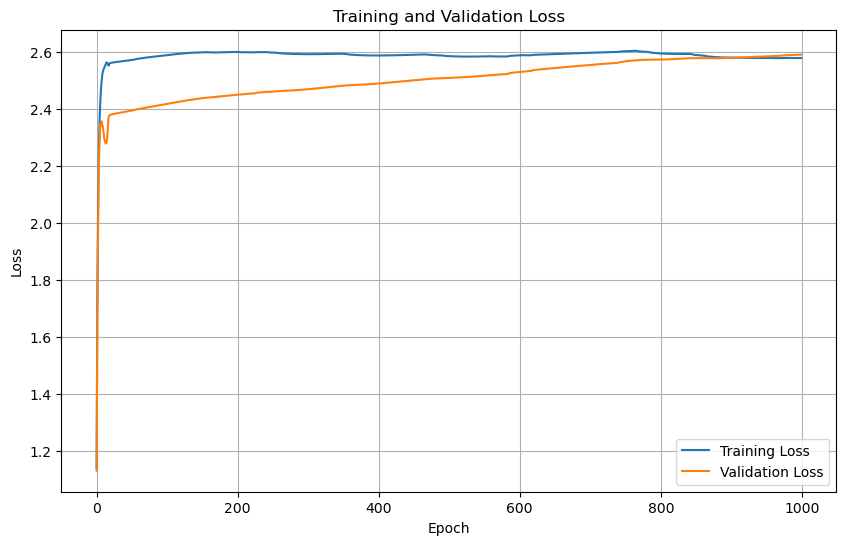

In [120]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
yhat_test_scaled shape: (400, 1)


C:\Users\alexa\AppData\Local\Temp\ipykernel_8336\2193529504.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_test_groups))


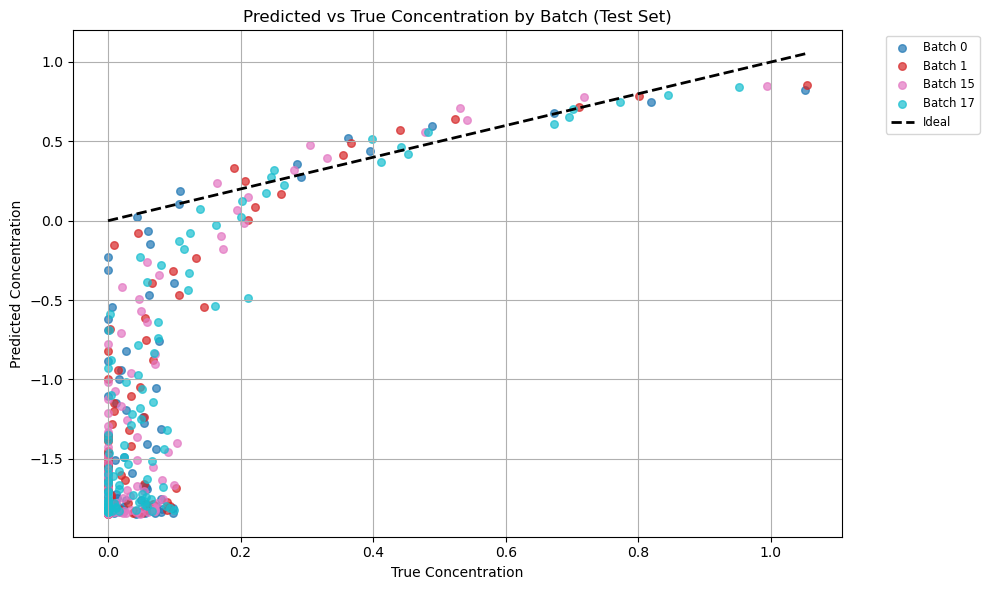

In [121]:
plt.figure(figsize=(10, 6))

# Convert test set to tensor
X_test_scaled_tensor = tf.convert_to_tensor(X_test_scaled, dtype=tf.float32)
yhat_test_scaled = model3.predict(X_test_scaled_tensor)
print("yhat_test_scaled shape:", yhat_test_scaled.shape)

# Unscale predictions using the inverse transform of scaler_y
yhat_test = scaler_y.inverse_transform(yhat_test_scaled.reshape(-1, 1)).flatten()

unique_test_groups = np.unique(test_groups)
colors = plt.cm.get_cmap('tab10', len(unique_test_groups))

for idx, group in enumerate(unique_test_groups):
    mask = (test_groups == group)
    plt.scatter(
        y_test[mask], 
        yhat_test[mask], 
        color=colors(idx), 
        label=f'Batch {int(group)}', 
        s=30, 
        alpha=0.7
    )

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Ideal')
plt.xlabel('True Concentration')
plt.ylabel('Predicted Concentration')
plt.title('Predicted vs True Concentration by Batch (Test Set)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()



C:\Users\alexa\AppData\Local\Temp\ipykernel_8336\517894425.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_test_groups))


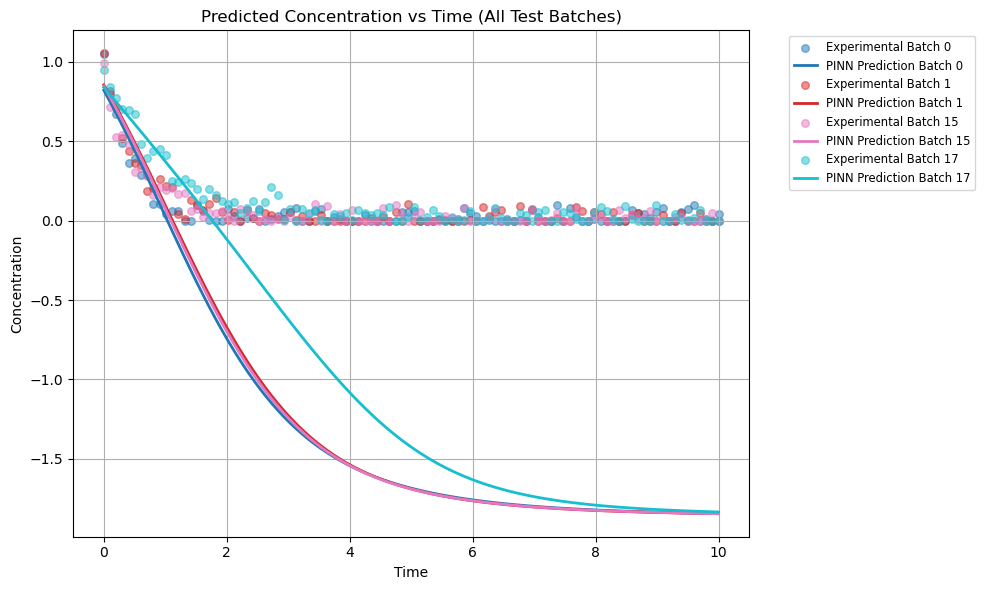

In [122]:
plt.figure(figsize=(10, 6))

unique_test_groups = np.unique(test_groups)
colors = plt.cm.get_cmap('tab10', len(unique_test_groups))

for idx, group in enumerate(unique_test_groups):
    mask = test_groups == group
    t_batch = X_test[mask, 0]
    Ccat_batch = X_test[mask, 1]
    yhat_batch = yhat_test[mask]
    y_batch = y_test[mask]
    plt.scatter(t_batch, y_batch, label=f'Experimental Batch {int(group)}', color=colors(idx), s=30, alpha=0.5)
    plt.plot(t_batch, yhat_batch, label=f'PINN Prediction Batch {int(group)}', color=colors(idx), linewidth=2)

plt.title('Predicted Concentration vs Time (All Test Batches)')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()


In [60]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

tf.random.set_seed(42)

from tensorflow import keras
from keras import layers, models

# Define a simple feedforward neural network
model = models.Sequential([
    layers.Input(shape=(2,)),  # Input shape: (t, C_cat)
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='tanh'),
    layers.Dense(1)  # Output: predicted concentration
])

# let's define the custom loss function
def pinn_loss(model, y, t, Ccat):
    l = 0.0 # lambda
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(t) # Only watch t, since we want dC/dt
        # for PDE, we would watch all the independent variables required to compute the derivatives
        # Concatenate t and Ccat into a single input tensor for the model
        inputs = tf.stack([t, Ccat], axis=1)
        #print("Inputs shape:", inputs.shape)
        yhat = model(inputs)
        # enforce the physic constraint that a concentration cannot be negative
        yhat = tf.where(yhat < 0, 0.0, yhat)
    dC_dt = tape.gradient(yhat, t)
    del tape
    # Calculate the residual of the ODE based on the **known** theoretical model!
    physics_loss = tf.reduce_mean(tf.square(dC_dt + k * tf.square(yhat)))  
    # remember, mechanistic theory is: dC/dt + k * C^2 = 0
    # we square to ensure loss is non-negative
    data_loss = tf.reduce_mean(tf.square(y - yhat))  # MSE loss
    return (1-l) * data_loss + l * physics_loss

scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# Optimizer
optimizer = keras.optimizers.Adam(learning_rate=0.0005)



In [7]:
# test pinn loss function
X_train_tensor = tf.convert_to_tensor(X_train_scaled, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train_scaled, dtype=tf.float32)
pinn_loss(model, y_train_tensor[:], X_train_tensor[:, 0:1], X_train_tensor[:, 1:2])

<tf.Tensor: shape=(), dtype=float32, numpy=1.0775130987167358>

Why this model architecture?

Epoch 0, Loss: 1.009299
Epoch 0, Loss: 1.009299


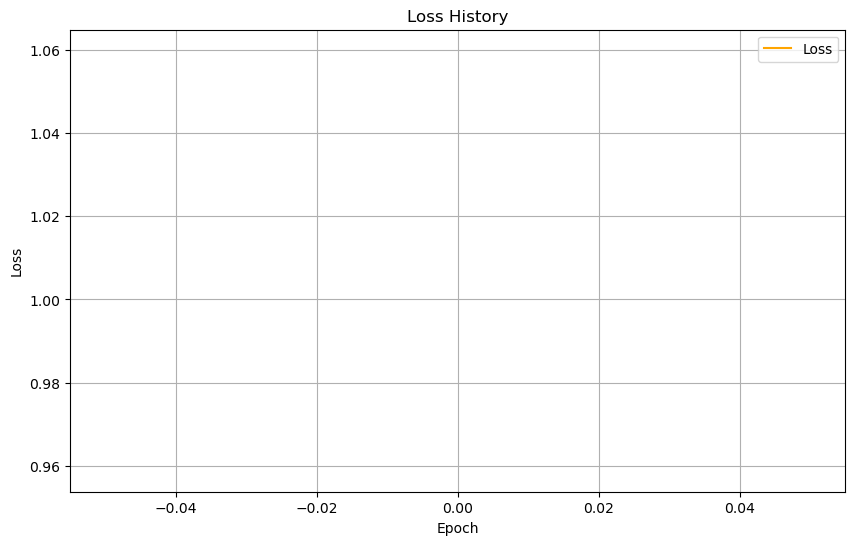

In [8]:
loss_history = []

BATCH_SIZE = 32
EPOCHS = 1
# Create tf.data.Dataset for batching
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_scaled, y_train_tensor))
train_dataset = train_dataset.shuffle(buffer_size=1024, seed=42).batch(BATCH_SIZE)

for epoch in range(EPOCHS):
    epoch_losses = []
    for X_batch_np, y_batch_np in train_dataset:
        X_batch = tf.convert_to_tensor(X_batch_np, dtype=tf.float32)
        y_batch = tf.convert_to_tensor(y_batch_np, dtype=tf.float32)
        with tf.GradientTape() as tape:
            #tape.watch(model.trainable_variables)
            loss = pinn_loss(model, y_batch, X_batch[:, 0:1], X_batch[:, 1:2])
        gradients = tape.gradient(loss, model.trainable_variables)
        del tape
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        epoch_losses.append(loss.numpy())
    epoch_loss_mean = np.mean(epoch_losses)
    loss_history.append(epoch_loss_mean)
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {epoch_loss_mean:.6f}')

print(f'Epoch {epoch}, Loss: {epoch_loss_mean:.6f}')

# Plot the loss history
plt.figure(figsize=(10, 6))
plt.plot(loss_history, label='Loss', color='orange')
plt.title('Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
yhat_test_scaled shape: (400, 1)


C:\Users\alexa\AppData\Local\Temp\ipykernel_8336\1736926390.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_test_groups))


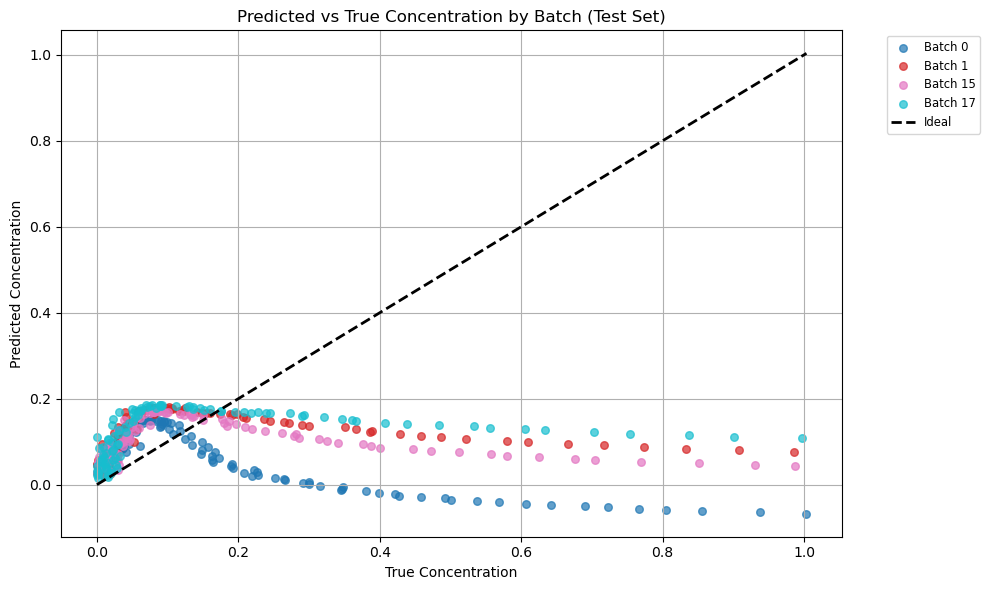

In [9]:
plt.figure(figsize=(10, 6))

# Convert test set to tensor
X_test_tensor = tf.convert_to_tensor(X_test_scaled, dtype=tf.float32)
yhat_test_scaled = model.predict(X_test_tensor)
print("yhat_test_scaled shape:", yhat_test_scaled.shape)

# Unscale predictions using the inverse transform of scaler_y
yhat_test = scaler_y.inverse_transform(yhat_test_scaled.reshape(-1, 1)).flatten()

unique_test_groups = np.unique(test_groups)
colors = plt.cm.get_cmap('tab10', len(unique_test_groups))

for idx, group in enumerate(unique_test_groups):
    mask = (test_groups == group)
    plt.scatter(
        y_test[mask], 
        yhat_test[mask], 
        color=colors(idx), 
        label=f'Batch {int(group)}', 
        s=30, 
        alpha=0.7
    )

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Ideal')
plt.xlabel('True Concentration')
plt.ylabel('Predicted Concentration')
plt.title('Predicted vs True Concentration by Batch (Test Set)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()



C:\Users\alexa\AppData\Local\Temp\ipykernel_8336\517894425.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_test_groups))


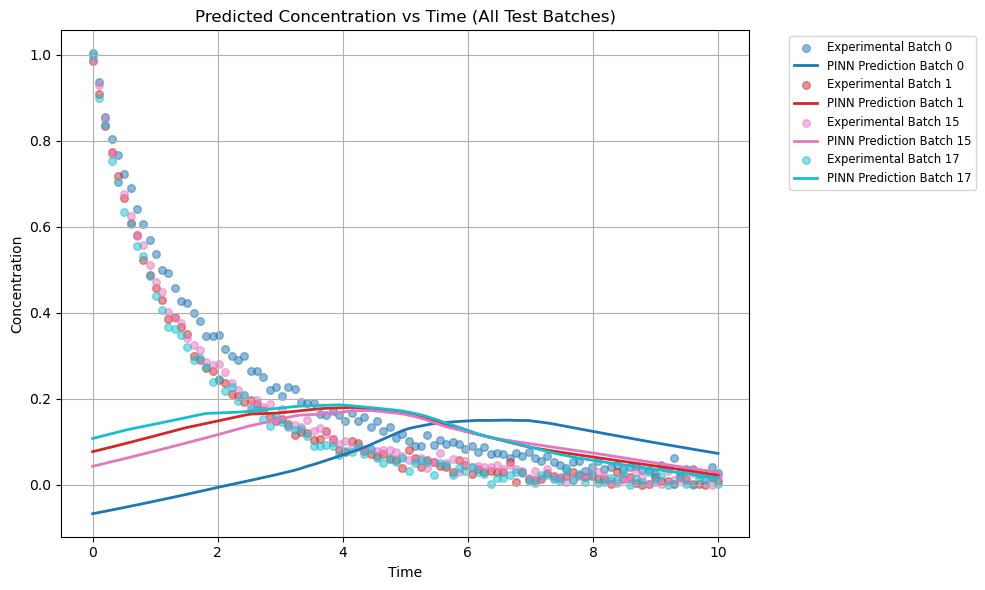

In [10]:
plt.figure(figsize=(10, 6))

unique_test_groups = np.unique(test_groups)
colors = plt.cm.get_cmap('tab10', len(unique_test_groups))

for idx, group in enumerate(unique_test_groups):
    mask = test_groups == group
    t_batch = X_test[mask, 0]
    Ccat_batch = X_test[mask, 1]
    yhat_batch = yhat_test[mask]
    y_batch = y_test[mask]
    plt.scatter(t_batch, y_batch, label=f'Experimental Batch {int(group)}', color=colors(idx), s=30, alpha=0.5)
    plt.plot(t_batch, yhat_batch, label=f'PINN Prediction Batch {int(group)}', color=colors(idx), linewidth=2)

plt.title('Predicted Concentration vs Time (All Test Batches)')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
from datetime import datetime
layer_inputs = layers.Input(shape=(2,), name='input')  # Input shape: (t, C_cat)
layer_dense_1= layers.Dense(32, activation='relu', name='layer_dense_1')(layer_inputs)
layer_dense_2= layers.Dense(32, activation='tanh', name='layer_dense_2')(layer_dense_1)  
layer_output = layers.Dense(1, name='output')(layer_dense_2)

model2 = keras.Model(layer_inputs, [layer_output], name='PINN_%s' % datetime.today().strftime('%Y-%m-%d-%H_%M') ) 

loss_mse = keras.losses.MeanSquaredError()

model2.compile(
    optimizer='adam',
    loss={'output': loss_mse},
    loss_weights =[1], #list of our loss weights
    metrics={'output': keras.metrics.MeanSquaredError()}
) 

In [12]:
model2.summary()

Model: "PINN_2025-06-10-10_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_dense_1 (Dense)           │ (None, 32)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_dense_2 (Dense)           │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,185 (4.63 KB)

 Trainable params: 1,185 (4.63 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
history = model2.fit(
    X_train_scaled, 
    y_train_scaled, 
    epochs=50, 
    batch_size=64, 
    shuffle=True,
    validation_data=(X_test_scaled, y_test_scaled), 
    verbose=2
)

Epoch 1/50
25/25 - 1s - 32ms/step - loss: 0.6656 - mean_squared_error: 0.6656 - val_loss: 0.3286 - val_mean_squared_error: 0.3286
Epoch 2/50
25/25 - 0s - 1ms/step - loss: 0.2464 - mean_squared_error: 0.2464 - val_loss: 0.2203 - val_mean_squared_error: 0.2203
Epoch 3/50
25/25 - 0s - 2ms/step - loss: 0.1783 - mean_squared_error: 0.1783 - val_loss: 0.1668 - val_mean_squared_error: 0.1668
Epoch 4/50
25/25 - 0s - 3ms/step - loss: 0.1375 - mean_squared_error: 0.1375 - val_loss: 0.1362 - val_mean_squared_error: 0.1362
Epoch 5/50
25/25 - 0s - 2ms/step - loss: 0.1138 - mean_squared_error: 0.1138 - val_loss: 0.1188 - val_mean_squared_error: 0.1188
Epoch 6/50
25/25 - 0s - 2ms/step - loss: 0.0998 - mean_squared_error: 0.0998 - val_loss: 0.1074 - val_mean_squared_error: 0.1074
Epoch 7/50
25/25 - 0s - 2ms/step - loss: 0.0903 - mean_squared_error: 0.0903 - val_loss: 0.0985 - val_mean_squared_error: 0.0985
Epoch 8/50
25/25 - 0s - 2ms/step - loss: 0.0827 - mean_squared_error: 0.0827 - val_loss: 0.0908 

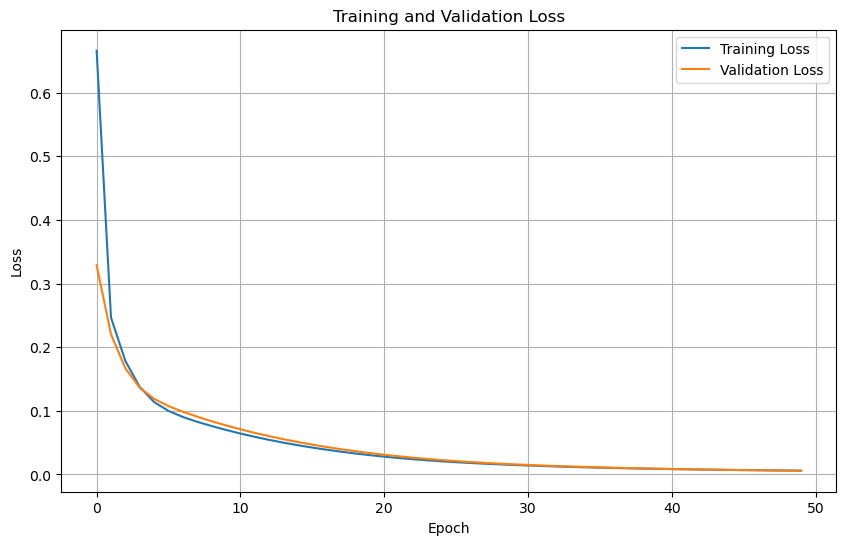

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
yhat_test_scaled shape: (400, 1)


C:\Users\alexa\AppData\Local\Temp\ipykernel_8336\3230913232.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_test_groups))


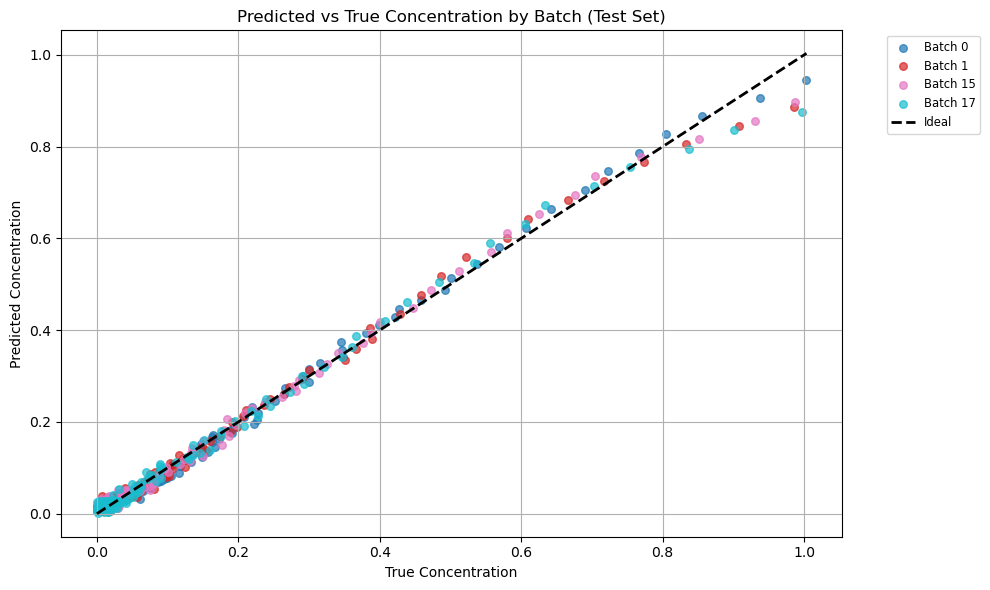

In [15]:
plt.figure(figsize=(10, 6))

# Convert test set to tensor
X_test_scaled_tensor = tf.convert_to_tensor(X_test_scaled, dtype=tf.float32)
yhat_test_scaled = model2.predict(X_test_scaled_tensor)
print("yhat_test_scaled shape:", yhat_test_scaled.shape)

# Unscale predictions using the inverse transform of scaler_y
yhat_test = scaler_y.inverse_transform(yhat_test_scaled.reshape(-1, 1)).flatten()

unique_test_groups = np.unique(test_groups)
colors = plt.cm.get_cmap('tab10', len(unique_test_groups))

for idx, group in enumerate(unique_test_groups):
    mask = (test_groups == group)
    plt.scatter(
        y_test[mask], 
        yhat_test[mask], 
        color=colors(idx), 
        label=f'Batch {int(group)}', 
        s=30, 
        alpha=0.7
    )

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Ideal')
plt.xlabel('True Concentration')
plt.ylabel('Predicted Concentration')
plt.title('Predicted vs True Concentration by Batch (Test Set)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()



C:\Users\alexa\AppData\Local\Temp\ipykernel_8336\517894425.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_test_groups))


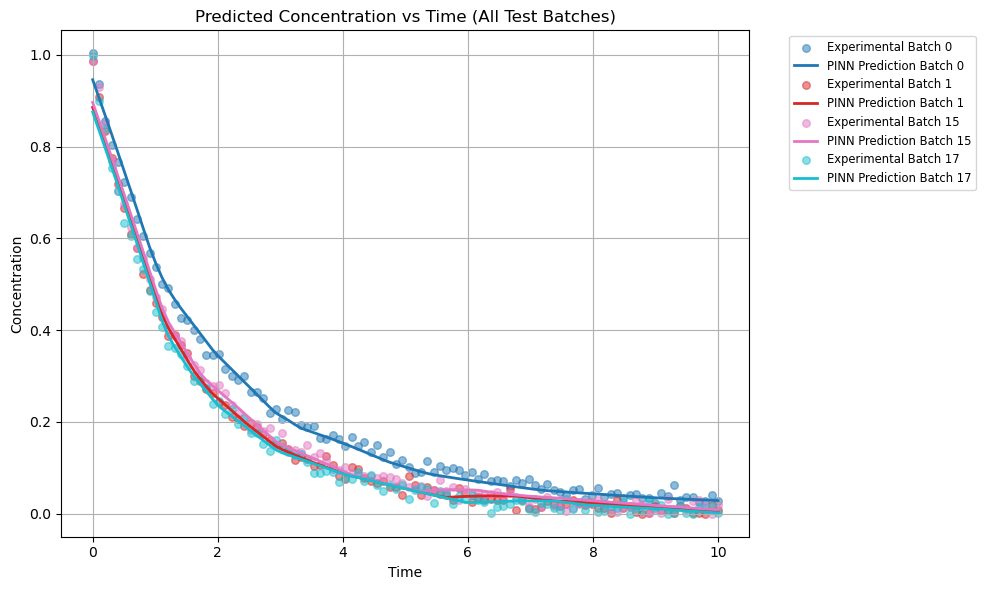

In [16]:
plt.figure(figsize=(10, 6))

unique_test_groups = np.unique(test_groups)
colors = plt.cm.get_cmap('tab10', len(unique_test_groups))

for idx, group in enumerate(unique_test_groups):
    mask = test_groups == group
    t_batch = X_test[mask, 0]
    Ccat_batch = X_test[mask, 1]
    yhat_batch = yhat_test[mask]
    y_batch = y_test[mask]
    plt.scatter(t_batch, y_batch, label=f'Experimental Batch {int(group)}', color=colors(idx), s=30, alpha=0.5)
    plt.plot(t_batch, yhat_batch, label=f'PINN Prediction Batch {int(group)}', color=colors(idx), linewidth=2)

plt.title('Predicted Concentration vs Time (All Test Batches)')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()


In [17]:
from keras import ops
from keras.src.losses.loss import Loss, squeeze_or_expand_to_same_rank

def mean_squared_error(y_true, y_pred):
    y_pred = ops.convert_to_tensor(y_pred)
    y_true = ops.convert_to_tensor(y_true, dtype=y_pred.dtype)
    y_true, y_pred = squeeze_or_expand_to_same_rank(y_true, y_pred)
    return ops.mean(ops.square(y_true - y_pred), axis=-1)

def mechanistic_equation(y_true, y_pred, dy_pred_dt, t, Ccat ):
    # print(
    #     "y_true shape:", y_true.shape, 
    #     "y_pred shape:", y_pred.shape, 
    #     "dy_pred_dt shape:", dy_pred_dt.shape, 
    #     "t shape:", t.shape, 
    #     "Ccat shape:", Ccat.shape
    # )
    k_cat = 10
    return ops.mean(ops.square(dy_pred_dt + k * ops.square(y_pred) + k_cat * Ccat * y_pred))

class PINNLoss(Loss):
    def __init__(self, lambda_=0.1, reduction="sum_over_batch_size", name=None):
        super().__init__(reduction=reduction, name=name)
        self.lambda_ = lambda_

    def call(self, y_true_packed, y_pred):
        # If y_true_packed is not the packed shape, just do MSE (for metrics/validation)
        # works for both (batch,) and (batch, 1) shapes.
        if (len(y_true_packed.shape) == 1) or (len(y_true_packed.shape) == 2 and y_true_packed.shape[1] == 1):
            print("y_true_packed shape:", y_true_packed.shape, "y_pred shape:", y_pred.shape)
            print("value ", y_true_packed, " and", y_pred)
            # fallback to standard MSE
            y_pred = ops.convert_to_tensor(y_pred)
            y_true = ops.convert_to_tensor(y_true_packed, dtype=y_pred.dtype)
            y_true, y_pred = squeeze_or_expand_to_same_rank(y_true, y_pred)
            val_data_loss = mean_squared_error(y_true, y_pred)
            if val_data_loss is None:
                raise ValueError("Data loss function must return a non-None value, even for validation.")
            print("revised y_true_packed shape:", y_true_packed.shape, "y_pred shape:", y_pred.shape)
            print("revised value ", y_true_packed, " and", y_pred)
            print("val loss:", val_data_loss)
            return val_data_loss
        
        
        print("y_true_packed shape:", y_true_packed.shape)
        # various checks, useful for debugging
        if len(y_true_packed.shape) != 2 or y_true_packed.shape[1] != 4:
            raise ValueError(f"y_true_packed must have 4 columns: [y_true, dy_pred_dt, t, Ccat]. Expected shape: (batch_size, 4), got {y_true_packed.shape}.")
        
        y_true = y_true_packed[:, 0:1]
        dy_pred_dt = y_true_packed[:, 1:2]
        t = y_true_packed[:, 2:3]
        Ccat = y_true_packed[:, 3:4]

        if dy_pred_dt is None:
            raise ValueError("Gradient tape must return a non-None value for dy_pred_dt.")
        if y_true.shape != y_pred.shape:
            raise ValueError(f"y_true and y_pred must have the same shape. Expected {y_true.shape}, got {y_pred.shape}.")
        if t.shape != dy_pred_dt.shape:
            raise ValueError(f"t and dy_pred_dt must have the same shape. Expected {t.shape}, got {dy_pred_dt.shape}.")
        if Ccat.shape != y_pred.shape:
            raise ValueError(f"Ccat and y_pred must have the same shape. Expected {Ccat.shape}, got {y_pred.shape}.")
        if y_true.dtype != y_pred.dtype:
            raise ValueError(f"y_true and y_pred must have the same dtype. Expected {y_true.dtype}, got {y_pred.dtype}.")
        if t.dtype != dy_pred_dt.dtype:
            raise ValueError(f"t and dy_pred_dt must have the same dtype. Expected {t.dtype}, got {dy_pred_dt.dtype}.")
        
        y_true, y_pred = squeeze_or_expand_to_same_rank(y_true, y_pred)
        physics_loss = mechanistic_equation(y_true, y_pred, dy_pred_dt, t, Ccat)
        if physics_loss is None:
            raise ValueError("Physics loss function must return a non-None value.")
        data_loss = mean_squared_error(y_true, y_pred)
        if data_loss is None:
            raise ValueError("Data loss function must return a non-None value.")
        train_total_loss = (1 - self.lambda_) * data_loss + self.lambda_ * physics_loss
        print("train total loss:", train_total_loss)
        return train_total_loss
    
    

In [18]:
class PINNModel(tf.keras.Model):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Add k_cat as a trainable variable, initialized to a reasonable value (e.g., 1.0)
        #self.k_cat = tf.Variable(1.0, trainable=True, dtype=tf.float32, name="k_cat")


    def train_step(self, data: tuple):
        print("Train step")
        print("size of data:", len(data))
        
        X, y_true = data
        with tf.GradientTape() as tape_1:
            with tf.GradientTape(persistent=True) as tape_2:
                tape_2.watch(X)
                y_pred = self(X, training=True)
                # y_pred = tf.where(y_pred < 0, 0.0, y_pred)  # Enforce non-negativity constraint
            # Assuming dy/dt is the first column of X. shape (batch_size, 1)
            dy_pred_dt = tape_2.gradient(y_pred, X)[:, 0:1] 
            #print("dy_pred_dt shape:", dy_pred_dt.shape)
            # Hack: Concatenate y_true, dy/dt and X to leverage the compiled loss function
            y_true_packed = tf.concat(
                [
                    tf.reshape(y_true, [-1, 1]), 
                    dy_pred_dt, 
                    X[:, 0:1], 
                    X[:, 1:2]
                ], 
                axis=1
            )  # shape: (batch_size, 4)
            # Call the compiled loss function
            # Note: self.compiled_loss is a callable that computes the loss
            # and applies any regularization losses
            print("<flag>")
            loss = self.compute_loss(X, y_true_packed, y_pred, training=True)
            print("</flag>")
        # Compute gradients and apply them
        gradients = tape_1.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        # Free memory
        del tape_1
        del tape_2
        # Update metrics (includes the metric(s) you passed in compile)
        for metric in self.metrics:
            metric.update_state(y_true, y_pred)
        # Return a dict mapping metric names to current value
        result = {
            "loss": loss,
            **{
                m.name: m.result() 
                for m in self.metrics
            }
        }
        return result
    
    def test_step(self, data: tuple):
        X, y_true = data
        print("Test step")
        print("size of data:", len(data))
        print(X, y_true)
        with tf.GradientTape(persistent=True) as tape_2:
            tape_2.watch(X)
            y_pred = self(X, training=False)
            # y_pred = tf.where(y_pred < 0, 0.0, y_pred)  # Enforce non-negativity constraint
        # Assuming dy/dt is the first column of X. shape (batch_size, 1)
        dy_pred_dt = tape_2.gradient(y_pred, X)[:, 0:1] 
        print("dy_pred_dt shape:", dy_pred_dt.shape)
        # Hack: Concatenate y_true, dy/dt and X to leverage the compiled loss function
        y_true_packed = tf.concat(
            [
                tf.reshape(y_true, [-1, 1]), 
                dy_pred_dt, 
                X[:, 0:1], 
                X[:, 1:2]
            ], 
            axis=1
        )  # shape: (batch_size, 4)
        # Call the compiled loss function
        # Note: self.compiled_loss is a callable that computes the loss
        # and applies any regularization losses
        print("<flag2>")
        loss = self.compute_loss(X, y_true_packed, y_pred, training=False)
        print("</flag2>")
        del tape_2
        
        # Update metrics
        for metric in self.metrics:
            metric.update_state(y_true, y_pred)
        # Return a dict mapping metric names to current value
        result = {
            "loss": loss,
            **{m.name: m.result() for m in self.metrics}
        }
        print("other flag")
        return result

In [35]:
def generate_PINN(n, L):
    """
    Generate a Physics-Informed Neural Network (PINN) model.
    
    Parameters:
    n (int): Number of hidden layers.
    L (int): Number of neurons in each hidden layer.
    
    Returns:
    model (tf.keras.Model): The generated PINN model.
    """
    inputs = layers.Input(shape=(2,), name='input')  # Input shape: (t, C_cat)
    x = inputs
    for i in range(n):
        x = layers.Dense(
            L,
            kernel_initializer='glorot_normal',
            bias_initializer='zeros',
            activation='tanh', 
            name=f'layer_dense_{i+1}'
        )(x)
    outputs = layers.Dense(1, name='output')(x)
    
    return PINNModel(inputs, outputs, name='PINN')


model3 = generate_PINN(n=2, L=16)

loss_pinn = PINNLoss(lambda_=0.1)  # Set lambda to 0 for now, we can adjust it later

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.96
)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

model3.compile(
    optimizer=optimizer,
    loss=loss_pinn,
    #loss_weights=[1],  # Not needed, loss_pinn already handles it
    #metrics=[tf.keras.metrics.MeanSquaredError()]
) 
model3.summary()

Model: "PINN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_dense_1 (Dense)           │ (None, 16)             │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_dense_2 (Dense)           │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 337 (1.32 KB)

 Trainable params: 337 (1.32 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
# y_train_pinn = np.stack([y_train_scaled, X_train_scaled[:, 0], X_train_scaled[:, 1]], axis=1)
# y_test_pinn = np.stack([y_test_scaled, X_test_scaled[:, 0], X_test_scaled[:, 1]], axis=1)

history = model3.fit(
    X_train_scaled, 
    y_train_scaled,
    epochs=50, 
    batch_size=32,
    shuffle=True,
    validation_data=(X_test_scaled, y_test_scaled), 
    verbose=1
)

Epoch 1/50
Train step
size of data: 2
<flag>
y_true_packed shape: (32, 4)
train total loss: Tensor("compile_loss/pinn_loss_6/add_2:0", shape=(32,), dtype=float32)
</flag>
Train step
size of data: 2
<flag>
y_true_packed shape: (32, 4)
train total loss: Tensor("compile_loss/pinn_loss_6/add_2:0", shape=(32,), dtype=float32)
</flag>
 3/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5863Test step
size of data: 2
Tensor("IteratorGetNext:0", shape=(None, 2), dtype=float32) Tensor("IteratorGetNext:1", shape=(None,), dtype=float32)
dy_pred_dt shape: (None, 1)
<flag2>
y_true_packed shape: (None, 4)
train total loss: Tensor("compile_loss/pinn_loss_6/add_2:0", shape=(None,), dtype=float32)
</flag2>
other flag
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.3260 - val_loss: 14.3189
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 20.7765 - val_loss: -37.8804
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 51.7807 - val_loss: -36.1772
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/s

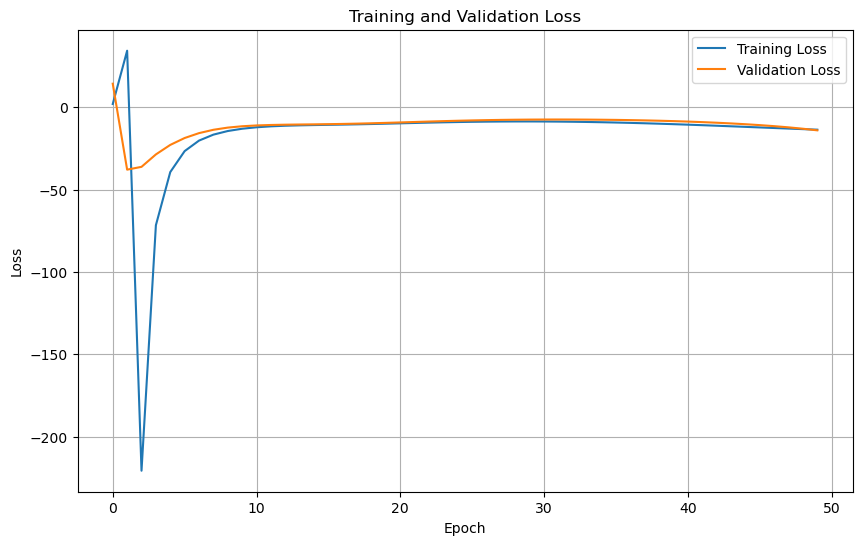

In [37]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
yhat_test_scaled shape: (400, 1)


C:\Users\alexa\AppData\Local\Temp\ipykernel_8336\2193529504.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_test_groups))


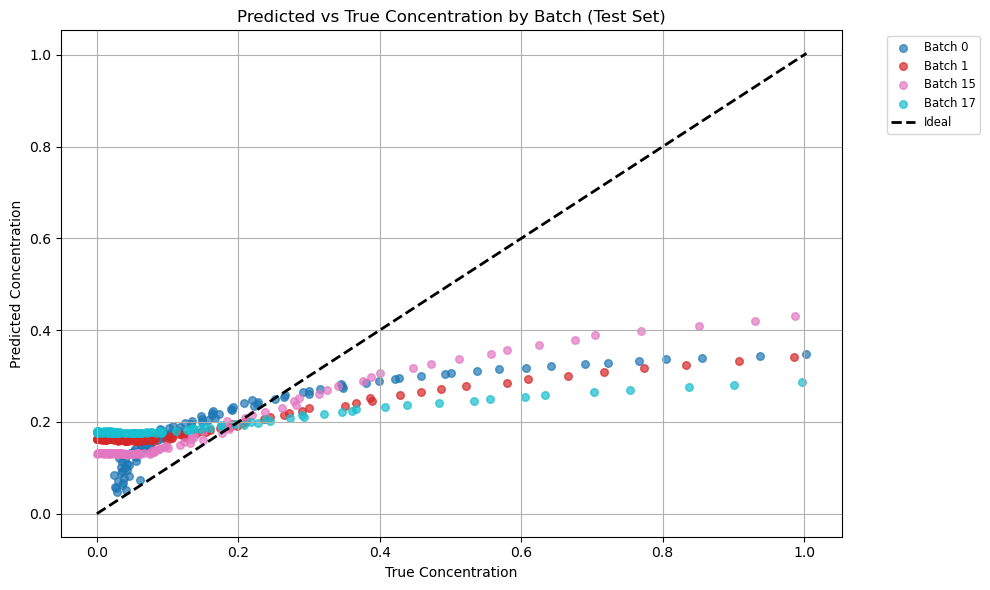

In [38]:
plt.figure(figsize=(10, 6))

# Convert test set to tensor
X_test_scaled_tensor = tf.convert_to_tensor(X_test_scaled, dtype=tf.float32)
yhat_test_scaled = model3.predict(X_test_scaled_tensor)
print("yhat_test_scaled shape:", yhat_test_scaled.shape)

# Unscale predictions using the inverse transform of scaler_y
yhat_test = scaler_y.inverse_transform(yhat_test_scaled.reshape(-1, 1)).flatten()

unique_test_groups = np.unique(test_groups)
colors = plt.cm.get_cmap('tab10', len(unique_test_groups))

for idx, group in enumerate(unique_test_groups):
    mask = (test_groups == group)
    plt.scatter(
        y_test[mask], 
        yhat_test[mask], 
        color=colors(idx), 
        label=f'Batch {int(group)}', 
        s=30, 
        alpha=0.7
    )

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Ideal')
plt.xlabel('True Concentration')
plt.ylabel('Predicted Concentration')
plt.title('Predicted vs True Concentration by Batch (Test Set)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
plt.figure(figsize=(10, 6))

unique_test_groups = np.unique(test_groups)
colors = plt.cm.get_cmap('tab10', len(unique_test_groups))

for idx, group in enumerate(unique_test_groups):
    mask = test_groups == group
    t_batch = X_test[mask, 0]
    Ccat_batch = X_test[mask, 1]
    yhat_batch = yhat_test[mask]
    y_batch = y_test[mask]
    plt.scatter(t_batch, y_batch, label=f'Experimental Batch {int(group)}', color=colors(idx), s=30, alpha=0.5)
    plt.plot(t_batch, yhat_batch, label=f'PINN Prediction Batch {int(group)}', color=colors(idx), linewidth=2)

plt.title('Predicted Concentration vs Time (All Test Batches)')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()
